<style>
  .darkpop-heading {
    font-family: 'Consolas', monospace;
    background-color: #2d3748;
    color: #f0f0f0;
    padding: 10px 15px;
    border-radius: 4px;
    margin: 20px 0;
    font-size: 1.1em;
    font-weight: bold;
    border-bottom: 3px solid #f6ad55;
    letter-spacing: 0.5px;
  }
</style>

<h2 class="darkpop-heading">Import Libraries</h2>

In [78]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [79]:
# Load data
df = pd.read_csv("../test.csv")

## Exploratory Data Analysis (EDA)

In [80]:
df.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,...,2,2,2,2,4,2,4,0,20.0,satisfied


In [81]:
df.shape

(25976, 25)

In [82]:
df.dtypes

Unnamed: 0                             int64
id                                     int64
Gender                                object
Customer Type                         object
Age                                    int64
Type of Travel                        object
Class                                 object
Flight Distance                        int64
Inflight wifi service                  int64
Departure/Arrival time convenient      int64
Ease of Online booking                 int64
Gate location                          int64
Food and drink                         int64
Online boarding                        int64
Seat comfort                           int64
Inflight entertainment                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Inflight service                       int64
Cleanliness                            int64
Departure 

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25976 entries, 0 to 25975
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         25976 non-null  int64  
 1   id                                 25976 non-null  int64  
 2   Gender                             25976 non-null  object 
 3   Customer Type                      25976 non-null  object 
 4   Age                                25976 non-null  int64  
 5   Type of Travel                     25976 non-null  object 
 6   Class                              25976 non-null  object 
 7   Flight Distance                    25976 non-null  int64  
 8   Inflight wifi service              25976 non-null  int64  
 9   Departure/Arrival time convenient  25976 non-null  int64  
 10  Ease of Online booking             25976 non-null  int64  
 11  Gate location                      25976 non-null  int

In [84]:
df.describe()

,Unnamed: 0,id,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.00000,25893.000000
mean,12987.500000,65005.657992,39.620958,1193.788459,2.724746,3.046812,2.756775,2.977094,3.215353,3.261665,3.449222,3.357753,3.385664,3.350169,3.633238,3.314175,3.649253,3.286226,14.30609,14.740857
std,7498.769632,37611.526647,15.135685,998.683999,1.335384,1.533371,1.412951,1.282133,1.331506,1.355536,1.320090,1.338299,1.282088,1.318862,1.176525,1.269332,1.180681,1.319330,37.42316,37.517539
min,0.000000,17.000000,7.000000,31.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000
25%,6493.750000,32170.500000,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.00000,0.000000
50%,12987.500000,65319.500000,40.000000,849.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.00000,0.000000
75%,19481.250000,97584.250000,51.000000,1744.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.00000,13.000000
max,25975.000000,129877.000000,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1128.00000,1115.000000


In [85]:
df.describe(include='object')

,Gender,Customer Type,Type of Travel,Class,satisfaction
count,25976,25976,25976,25976,25976
unique,2,2,2,3,2
top,Female,Loyal Customer,Business travel,Business,neutral or dissatisfied
freq,13172,21177,18038,12495,14573


In [86]:
df.isnull().sum()

Unnamed: 0                            0
id                                    0
Gender                                0
Customer Type                         0
Age                                   0
Type of Travel                        0
Class                                 0
Flight Distance                       0
Inflight wifi service                 0
Departure/Arrival time convenient     0
Ease of Online booking                0
Gate location                         0
Food and drink                        0
Online boarding                       0
Seat comfort                          0
Inflight entertainment                0
On-board service                      0
Leg room service                      0
Baggage handling                      0
Checkin service                       0
Inflight service                      0
Cleanliness                           0
Departure Delay in Minutes            0
Arrival Delay in Minutes             83
satisfaction                          0


In [87]:
df.duplicated().sum()

np.int64(0)

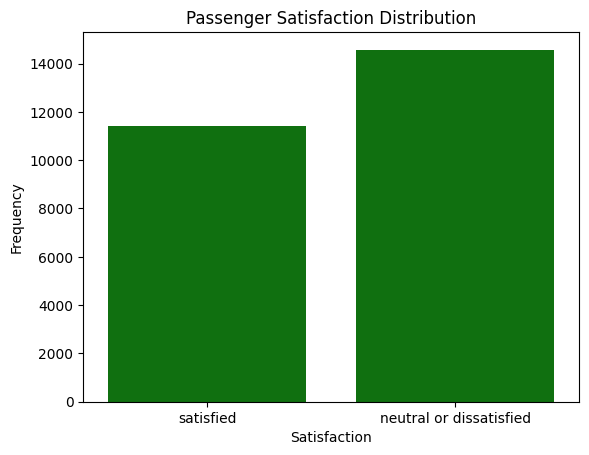

In [112]:
sns.countplot(data=df, x='satisfaction',color='green')
plt.title('Passenger Satisfaction Distribution')
plt.xlabel('Satisfaction')
plt.ylabel('Frequency')
plt.show()

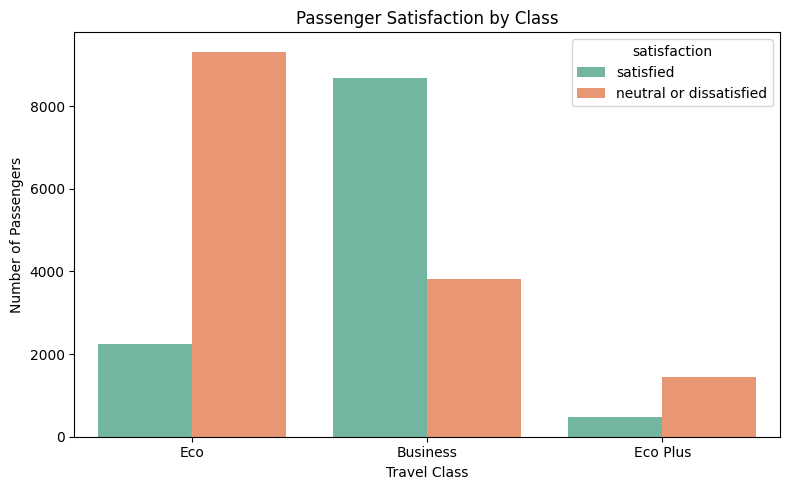

In [119]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Class', hue='satisfaction', data=df, palette='Set2')
plt.title('Passenger Satisfaction by Class')
plt.xlabel('Travel Class')
plt.ylabel('Number of Passengers')
plt.tight_layout()
plt.show()

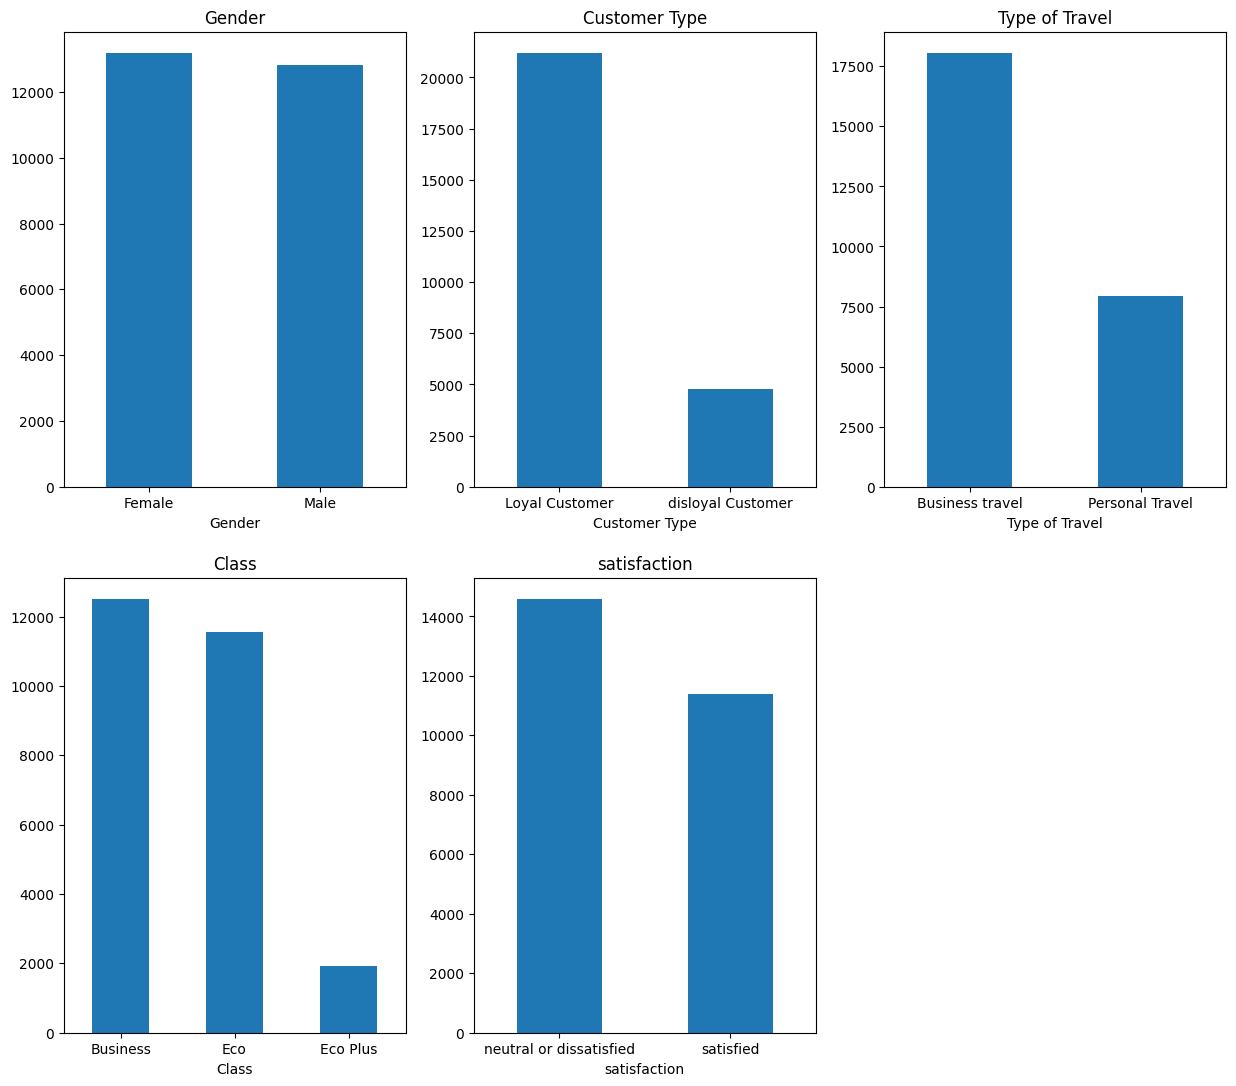

In [89]:
df_plotting =df.select_dtypes(include='object')
plt.figure(figsize=(15, 13))
for i, column in enumerate(df_plotting.columns, 1):
    plt.subplot(2, 3, i)
    df[column].value_counts().plot(kind='bar')
    plt.title(column)
    plt.xticks(rotation = 0)

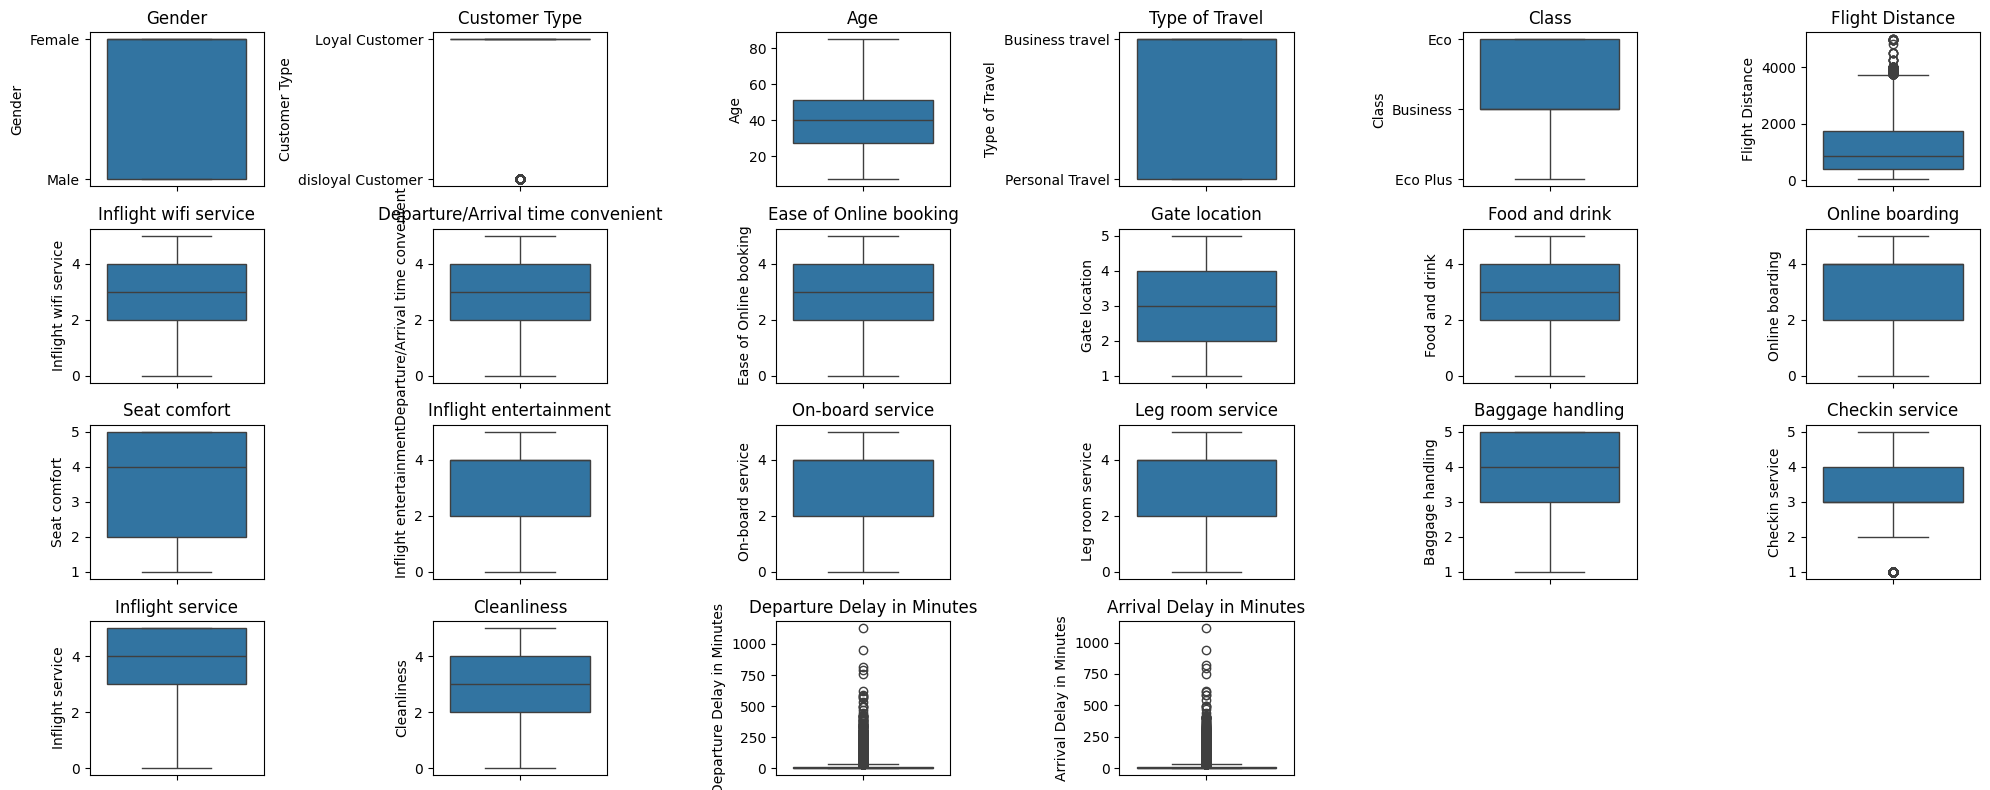

In [90]:
df_plotting=df.iloc[:,2:-1]
plt.figure(figsize=(20, 8))
for i, column in enumerate(df_plotting.columns, 1):
    plt.subplot(4, 6, i)
    sns.boxplot(y=df[column])
    plt.title(column)

plt.tight_layout()
plt.show()

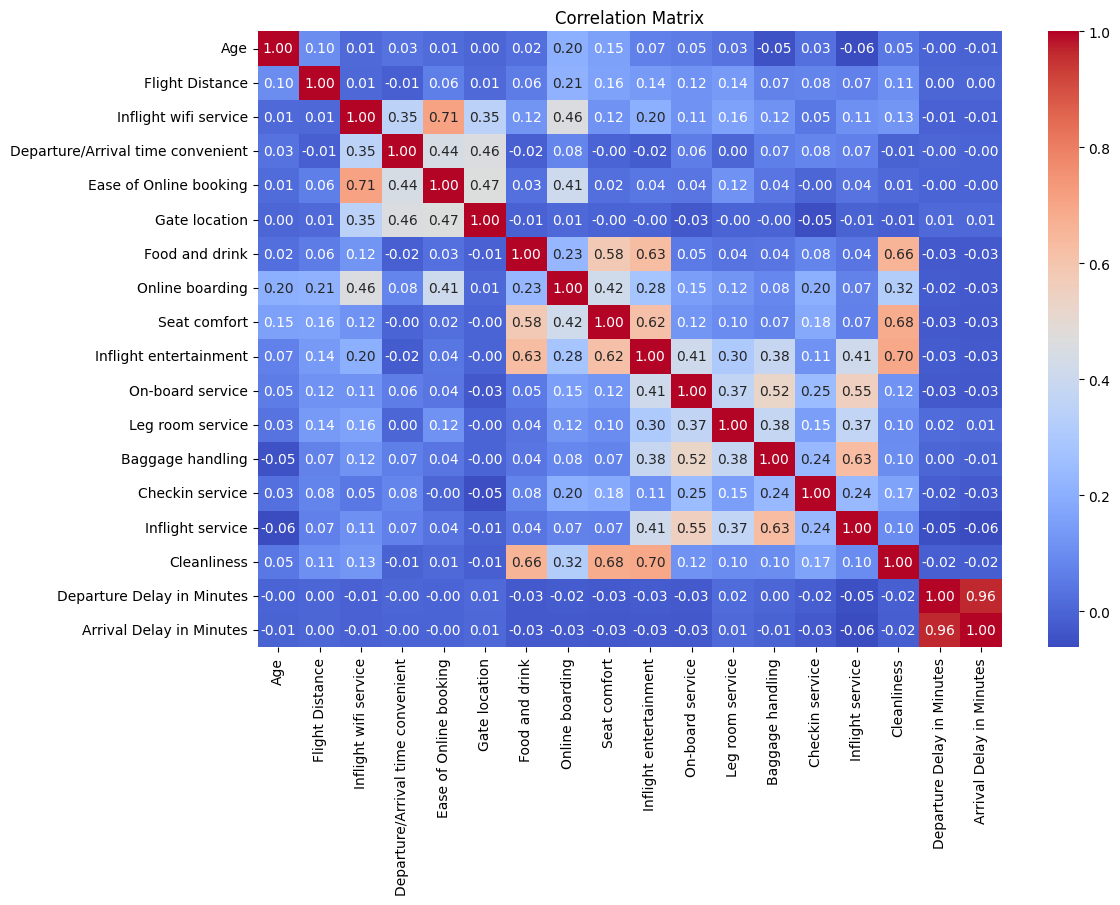

In [91]:
plt.figure(figsize=(12, 8))
numeric_data = df.iloc[:, 2:].select_dtypes(include='number')
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

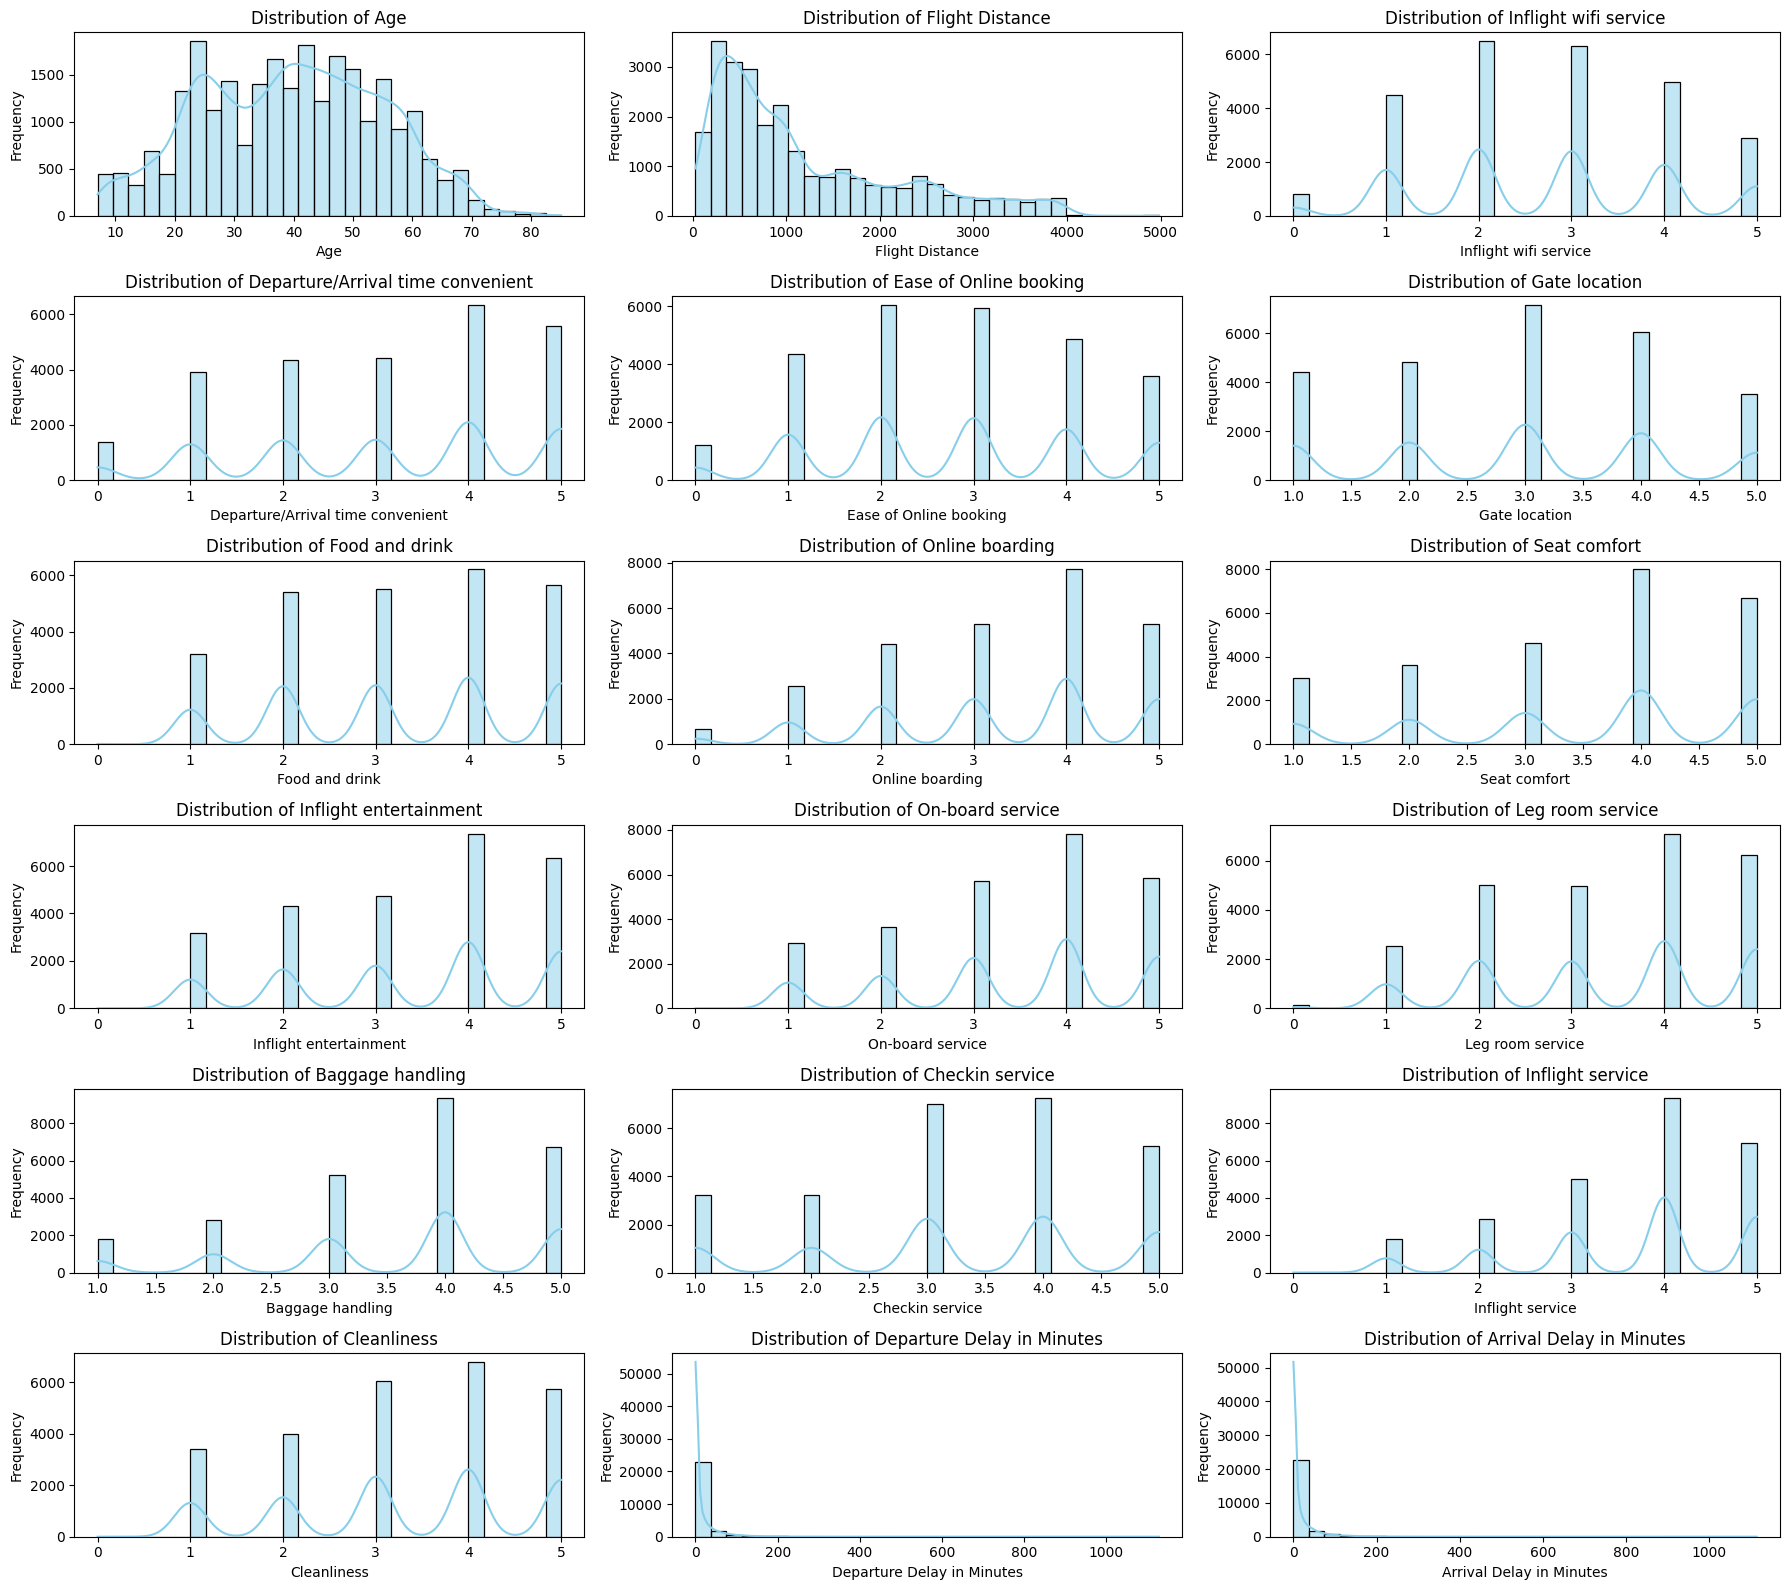

In [92]:
def plot_histograms():
    # This code selects only the numeric types and get its distribution
    numeric_cols = df.iloc[:, 2:].select_dtypes(include=['int64', 'float64']).columns.tolist()

    plt.figure(figsize=(18, 16))
    for idx, col in enumerate(numeric_cols):
        plt.subplot((len(numeric_cols) + 2) // 3, 3, idx + 1)
        sns.histplot(df[col], kde=True, color="skyblue", bins=30)
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
    
    plt.tight_layout() 
    plt.show()

plot_histograms()

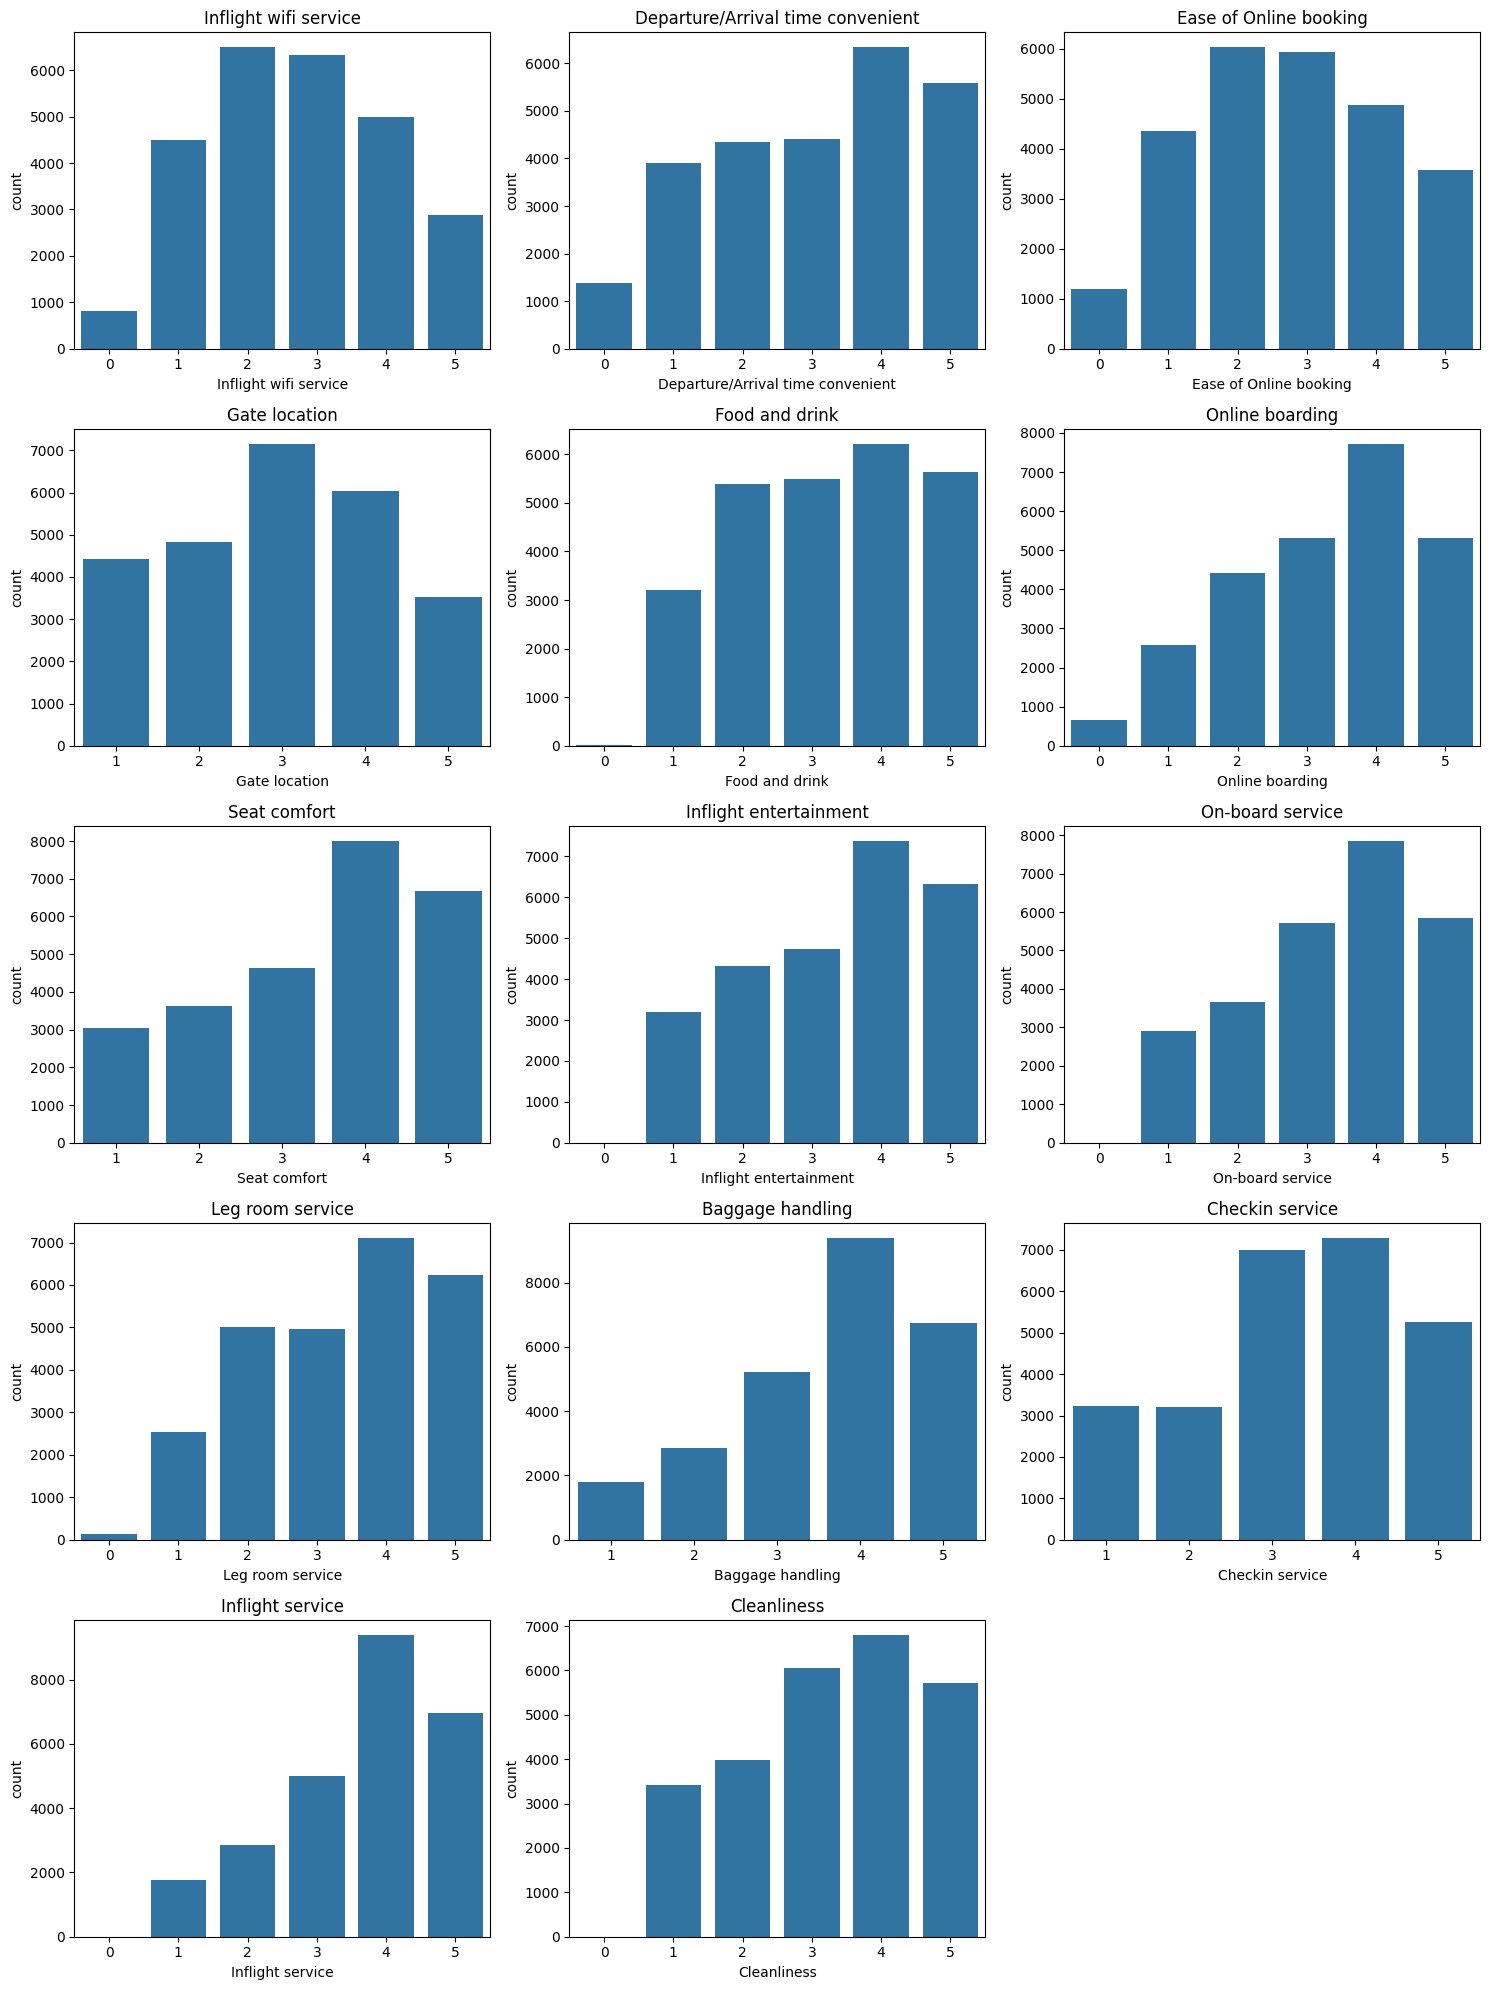

In [93]:
service_columns = [
    'Inflight wifi service',
    'Departure/Arrival time convenient',
    'Ease of Online booking',
    'Gate location',
    'Food and drink',
    'Online boarding',
    'Seat comfort',
    'Inflight entertainment',
    'On-board service',
    'Leg room service',
    'Baggage handling',
    'Checkin service',
    'Inflight service',
    'Cleanliness'
]

# Plot distribution of service rating
plt.figure(figsize=(15, 20))
for i, col in enumerate(service_columns, 1):
    plt.subplot(5, 3, i)
    sns.countplot(x=col, data=df)
    plt.title(col)
plt.tight_layout()
plt.show()

## **Insights**

### **1. Data Quality Issues**
- **Missing Values**:  
  - `Arrival Delay in Minutes` had 83 missing values

---

### **2. Data Distribution Insights**
- **Service Ratings**:  
  - 45% of passengers rated `Inflight wifi service` ≤2 (low satisfaction).  
  - `Food and drink` high at 2 (dissatisfied) and 5 (very satisfied).  

---

### **3. Correlation**
- **Strong Correlation**:  
  - `Departure Delay in Minutes` and `Arrival Delay in Minutes` (r=0.96)

- **Weak Correlation**:  
  - `Age` and `Seat comfort` (r=0.02) 

---

### **4. Categorical Insights**
- **Travel Class Impact**:  
  - 72% of `Business` class passengers reported "Satisfied" vs. 42% in `Eco`.  

<style>
  .darkpop-heading {
    font-family: 'Consolas', monospace;
    background-color: #2d3748;
    color: #f0f0f0;
    padding: 10px 15px;
    border-radius: 4px;
    margin: 20px 0;
    font-size: 1.1em;
    font-weight: bold;
    border-bottom: 3px solid #f6ad55;
    letter-spacing: 0.5px;
  }
</style>

<h2 class="darkpop-heading">Data Cleaning</h2>

In [94]:
# Drop unnecessary columns
df.drop(columns=["Unnamed: 0", "id"], inplace=True)

In [95]:
### Check for Inaccurate or Invalid Entries (examples)

print("\n INACCURATE / INVALID ENTRIES CHECK (Example Rules):")

# Age should be positive and realistic
invalid_age = df[df['Age'] <= 0]
print(f"Invalid 'Age' entries: {len(invalid_age)}")

# Flight Distance should be positive
invalid_distance = df[df['Flight Distance'] <= 0]
print(f"Invalid 'Flight Distance' entries: {len(invalid_distance)}")

# Ratings should be within 0–5
rating_cols = [col for col in df.columns if 'service' in col.lower() or 'rating' in col.lower()]
for col in rating_cols:
    if col in df.columns:
        invalid = df[(df[col] < 0) | (df[col] > 5)]
        print(f"Invalid ratings in '{col}': {len(invalid)}")



 INACCURATE / INVALID ENTRIES CHECK (Example Rules):
Invalid 'Age' entries: 0
Invalid 'Flight Distance' entries: 0
Invalid ratings in 'Inflight wifi service': 0
Invalid ratings in 'On-board service': 0
Invalid ratings in 'Leg room service': 0
Invalid ratings in 'Checkin service': 0
Invalid ratings in 'Inflight service': 0


<style>
  .darkpop-heading {
    font-family: 'Consolas', monospace;
    background-color: #2d3748;
    color: #f0f0f0;
    padding: 10px 15px;
    border-radius: 4px;
    margin: 20px 0;
    font-size: 1.1em;
    font-weight: bold;
    border-bottom: 3px solid #f6ad55;
    letter-spacing: 0.5px;
  }
</style>

<h3 class="darkpop-heading">Split Dataset</h3>

In [96]:
X = df.drop("satisfaction", axis=1)
y = df["satisfaction"]

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 , stratify=y)

In [98]:
X_train.shape , X_test.shape , y_train.shape , y_test.shape

((20780, 22), (5196, 22), (20780,), (5196,))

In [99]:
# Identify column types
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

We used median for Arrival Delay in Minutes because it's a real-world numeric value that often includes extreme outliers (like major flight delays). Using the mean could distort the imputation and mislead the model.

<style>
  .darkpop-heading {
    font-family: 'Consolas', monospace;
    background-color: #2d3748;
    color: #f0f0f0;
    padding: 10px 15px;
    border-radius: 4px;
    margin: 20px 0;
    font-size: 1.1em;
    font-weight: bold;
    border-bottom: 3px solid #f6ad55;
    letter-spacing: 0.5px;
  }
</style>

<h3 class="darkpop-heading">ColumnTransformer</h3>

In [100]:
# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numerical_cols),
    ("cat", categorical_transformer, categorical_cols)
])

<style>
  .darkpop-heading {
    font-family: 'Consolas', monospace;
    background-color: #2d3748;
    color: #f0f0f0;
    padding: 10px 15px;
    border-radius: 4px;
    margin: 20px 0;
    font-size: 1.1em;
    font-weight: bold;
    border-bottom: 3px solid #f6ad55;
    letter-spacing: 0.5px;
  }
</style>

<h3 class="darkpop-heading">Pipeline (preprocessing + PCA + SVM)</h3>

In [101]:
# Build full pipeline with PCA and SVM
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("pca", PCA(n_components=0.95)),
    ("classifier", SVC())
])

<style>
  .darkpop-heading {
    font-family: 'Consolas', monospace;
    background-color: #2d3748;
    color: #f0f0f0;
    padding: 10px 15px;
    border-radius: 4px;
    margin: 20px 0;
    font-size: 1.1em;
    font-weight: bold;
    border-bottom: 3px solid #f6ad55;
    letter-spacing: 0.5px;
  }
</style>

<h3 class="darkpop-heading">Grid search (Optimization)</h3>

In [102]:
# Grid search for hyperparameter tuning
param_grid = {
    "classifier__C": [0.1, 1, 10],
    "classifier__kernel": ["rbf", "linear"],
    "classifier__gamma": ["scale", "auto"]
}

<style>
  .darkpop-heading {
    font-family: 'Consolas', monospace;
    background-color: #2d3748;
    color: #f0f0f0;
    padding: 10px 15px;
    border-radius: 4px;
    margin: 20px 0;
    font-size: 1.1em;
    font-weight: bold;
    border-bottom: 3px solid #f6ad55;
    letter-spacing: 0.5px;
  }
</style>

<h3 class="darkpop-heading">Model Fitting</h3>

In [103]:
grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Flight '
                                                                          'Distance',
                                                                          'Inflight '
                                                                          'wifi '
                                                                          'service',
                                                                          'Departure/Arrival '
                                                                          'time '
                                                                          'convenient',
                                                                          'Ease '
                                                                          'of '
                                                                          'Online '
                                                                          'booking',
                                                                          'Gate '
                                                                          'location',
                                                                          'Food '
                                                                          'and '
                                                                          'drink',
                                                                          'Onlin...
                                                                          'Arrival '
                                                                          'Delay '
                                                                          'in '
                                                                          'Minutes']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Gender',
                                                                          'Customer '
                                                                          'Type',
                                                                          'Type '
                                                                          'of '
                                                                          'Travel',
                                                                          'Class'])])),
                                       ('pca', PCA(n_components=0.95)),
                                       ('classifier', SVC())]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.1, 1, 10],
                         'classifier__gamma': ['scale', 'auto'],
                         'classifier__kernel': ['rbf', 'linear']},
             verbose=1)

In [104]:
best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

Best parameters: {'classifier__C': 10, 'classifier__gamma': 'auto', 'classifier__kernel': 'rbf'}


<style>
  .darkpop-heading {
    font-family: 'Consolas', monospace;
    background-color: #2d3748;
    color: #f0f0f0;
    padding: 10px 15px;
    border-radius: 4px;
    margin: 20px 0;
    font-size: 1.1em;
    font-weight: bold;
    border-bottom: 3px solid #f6ad55;
    letter-spacing: 0.5px;
  }
</style>

<h3 class="darkpop-heading">Model Evaluation</h3>

In [105]:
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9382217090069284


In [106]:
# Classification report
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

neutral or dissatisfied       0.94      0.95      0.95      2915
              satisfied       0.94      0.92      0.93      2281

               accuracy                           0.94      5196
              macro avg       0.94      0.94      0.94      5196
           weighted avg       0.94      0.94      0.94      5196



Confusion Matrix:
[[2778  137]
 [ 184 2097]]


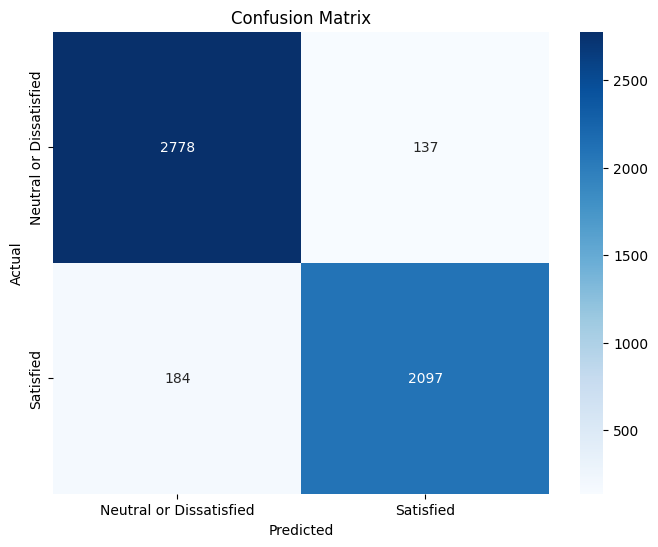

In [107]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

#Plot the confusion matrix (optional)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Neutral or Dissatisfied", "Satisfied"],
            yticklabels=["Neutral or Dissatisfied", "Satisfied"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


<style>
  .darkpop-heading {
    font-family: 'Consolas', monospace;
    background-color: #2d3748;
    color: #f0f0f0;
    padding: 10px 15px;
    border-radius: 4px;
    margin: 20px 0;
    font-size: 1.1em;
    font-weight: bold;
    border-bottom: 3px solid #f6ad55;
    letter-spacing: 0.5px;
  }
</style>

<h3 class="darkpop-heading">Pipeline Saving</h3>

In [108]:
# Saving the model
import pickle
with open("SVM_grid_search.pkl", "wb") as file:
    pickle.dump(grid_search, file)

In [109]:
from google.colab import files
files.download("SVM_grid_search.pkl")

ModuleNotFoundError: No module named 'google.colab'